In [140]:
import torch
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
from torch import randn
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn

import random, os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas

%matplotlib inline

In [141]:
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [142]:
def dy_dx(y, x):
  return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def d2y_dx2(y, x):
  return dy_dx(dy_dx(y,x), x)

def d3y_dx3(y, x):
  return dy_dx(d2y_dx2(y,x), x)


In [143]:
domain = [0, 6]
n_discretization = 100 * domain[1] - domain[0]

In [144]:
n_input = 1
n_output = 1
eps = 1e-10

In [145]:
x = torch.linspace(domain[0] + eps, domain[1] - eps, n_discretization).reshape(-1,1)
x = Variable(x, requires_grad=True).double()

In [146]:
mlp = nn.Sequential(
  nn.Linear(n_input, 32),
  nn.Tanh(),
  nn.Linear(32, 64),
  nn.Tanh(),
  nn.Linear(64, 128),
  nn.Tanh(),
  nn.Linear(128, 64),
  nn.Tanh(),        
  nn.Linear(64, 16),
  nn.Linear(16, n_output)
).double()

In [147]:
def get_loss(x, ret_res=False):    
  y = mlp(x)
  y_x = dy_dx(y, x)
  y_xx = dy_dx(y_x, x)
  y_xxx = dy_dx(y_xx, x)


  """    
  Blasius Eq.: 
   f''' + 0.5 ff'' = 0
   2f''' + ff'' = 0   ,   f(0) = f'(0) = 0
  """
  
  residual = (2 * y_xxx) + (y_xx * y)


  """ 
   Falkner Skan Eq.:
   2f''' + ff'' + β(1 - (f')^2) = 0   ,   f(0) = f'(0) = 0
  """
  
  m = 0.11        # m ∈ [-0.0905, 2]
  beta = (2 * m) / (1 + m)
  #TODO check for various betas

  # residual = 2 * y_xxx + y_xx * y + beta * (1 - y_x**2)

  # boundaries same for all equations
  boundary1 = y[0] - 0
  boundary2 = y_x[0] - 0

  loss = (residual**2).mean() + boundary1**2 + boundary2**2
  return (loss, residual) if ret_res else loss

In [148]:
def closure():
  loss = get_loss(x)
  optimizer.zero_grad()
  loss.backward()
  return loss

In [149]:
#TODO
optimizer = optim.Adam(list(mlp.parameters()), lr=0.01, betas=(0.9, 0.999), eps=1e-32)
previous = 0
losses = []
epoch_Adam = 100
epoch_LBFGS = 1000
for i in range(epoch_Adam):
  loss = get_loss(x)
  
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i, loss))        
  
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.detach().numpy())


optimizer = optim.LBFGS(list(mlp.parameters()), lr = 0.01)
previous = 0
for i in range(epoch_LBFGS):
  loss = get_loss(x)
  if i % 2 == 0:        
    print('Step: %03d loss = %016.10f' % (i+epoch_Adam, loss))
    if abs(previous - loss) < 1e-10:
        print('converged')
        break
    
    previous = loss
  
  losses.append(loss.detach().numpy())
  optimizer.step(closure)

print("Final loss = %.2e" % get_loss(x))

Step: 000 loss = 00000.0600623632
Step: 002 loss = 00000.0535275879
Step: 004 loss = 00000.0067000964
Step: 006 loss = 00000.0021487124
Step: 008 loss = 00000.0244684909
Step: 010 loss = 00000.0075333855
Step: 012 loss = 00000.0097266927
Step: 014 loss = 00000.0055689885
Step: 016 loss = 00000.0021629095
Step: 018 loss = 00000.0017104776
Step: 020 loss = 00000.0016264851
Step: 022 loss = 00000.0014603752
Step: 024 loss = 00000.0018253799
Step: 026 loss = 00000.0012462775
Step: 028 loss = 00000.0002779217
Step: 030 loss = 00000.0002393344
Step: 032 loss = 00000.0007309145
Step: 034 loss = 00000.0005657538
Step: 036 loss = 00000.0000970124
Step: 038 loss = 00000.0001205874
Step: 040 loss = 00000.0003085954
Step: 042 loss = 00000.0001951205
Step: 044 loss = 00000.0000158610
Step: 046 loss = 00000.0000477584
Step: 048 loss = 00000.0001384223
Step: 050 loss = 00000.0001100906
Step: 052 loss = 00000.0000329244
Step: 054 loss = 00000.0000194737
Step: 056 loss = 00000.0000532577
Step: 058 loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


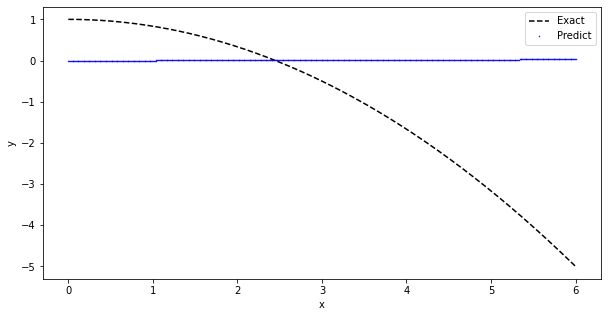

In [150]:
#[TODO]
domain = x.detach().numpy().flatten()
exact = (1 - x**2 / 6).detach().numpy().flatten()
predict = mlp.forward(x).detach().numpy().flatten()

plt.figure(figsize=(10, 5))
plt.xlabel('x')
plt.ylabel('y')

plt.plot(domain, exact,'k--', markersize=.1, label='Exact')
plt.plot(domain, predict,'b.', markersize=1, label='Predict')
plt.legend()

plt.savefig('exact-predict.eps', bbox_inches='tight', format='eps')

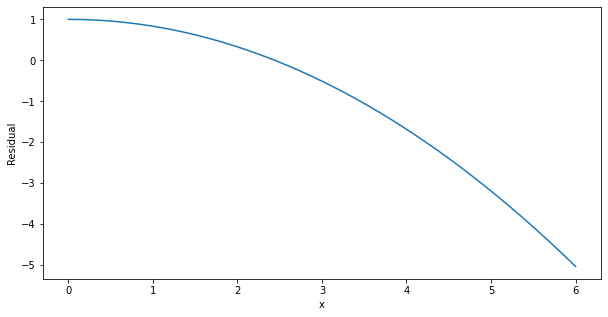

In [151]:
plt.figure(figsize=(10, 5))
plt.plot(domain, exact - predict, label='residual')
plt.xlabel('x')
plt.ylabel('Residual')
plt.savefig('residual-exact.eps', bbox_inches='tight', format='eps')


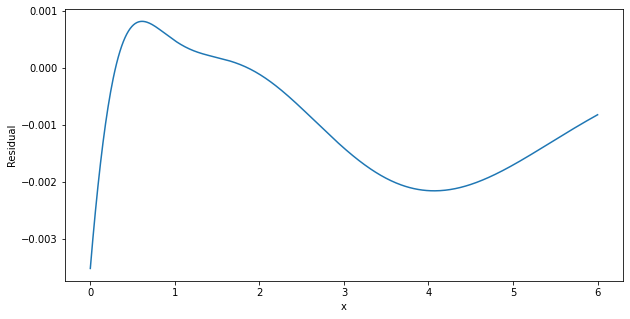

In [152]:
plt.figure(figsize=(10, 5))

res= get_loss(x, ret_res=True)[1].detach().numpy()
plt.xlabel('x')
plt.ylabel('Residual')
plt.plot(domain, res)
plt.savefig('residual-loss.eps', bbox_inches='tight', format='eps')

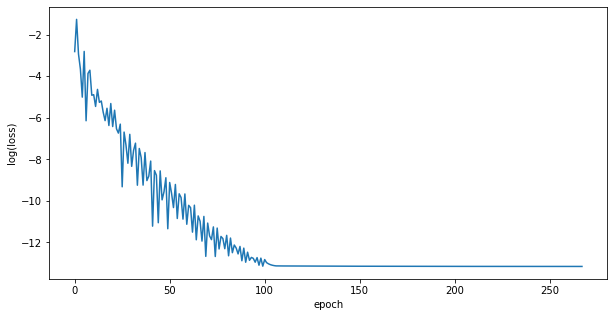

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(np.log(losses))
plt.xlabel('epoch')
plt.ylabel('log(loss)')

plt.savefig('loss.eps', bbox_inches='tight', format='eps')

In [154]:

def l1_norm(vector0, vector1):
  return sum(abs(a-b) for a, b in zip(vector0, vector1))

def l_inf_norm(vector0, vector1):
  return max(abs(a-b) for a, b in zip(vector0, vector1))

def l2_norm(vector0, vector1):
  return (sum((a-b)**2 for a, b in zip(vector0, vector1))) ** .5

def relative_l2(vector0, vector1):
  return np.linalg.norm(vector0 - vector1, 2)/np.linalg.norm(vector0,2)


measure_names = []
measure_values = []
for measure in [
  mean_squared_error,
  l1_norm,
  l2_norm,
  l_inf_norm,
  relative_l2,
  mean_absolute_error

]:
  measure_names.append(measure.__name__)
  measure_values.append(measure(exact, predict))
df = pandas.DataFrame(dict(name=measure_names, values=measure_values)).reset_index(drop=True)
print(df.to_latex(), file=open('latex_table.txt', 'w'))
df

/tmp/ipykernel_256748/1445887567.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(), file=open('latex_table.txt', 'w'))


,name,values
0,mean_squared_error,4.270555
1,l1_norm,933.714779
2,l2_norm,50.619492
3,l_inf_norm,5.029988
4,relative_l2,1.006605
5,mean_absolute_error,1.556191
